In [1]:
import sys

sys.path.append('/project/3022057.01/IFA/utils')

import os
import json
from preprocessing import get_groups, continuous_confounders, categorical_confounders
from pyriemann.estimation import Covariances
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold
import subprocess
import pickle
from analysis import evaluate_IFA_results


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
settings = {
    "phenotype": "PicVocab_AgeAdj",
    "percentile": 0.1,
    "outputfolder": "Run_5",
    "n_folds": 5,
    "random_state": 42,
    "n_filters_per_group": 2,
    "nPCA": 90,
    "Tangent_Class": True,
    "metric": "logeuclid",
    "a_label": 1,
    "b_label": 0,
    "self_whiten": False,
    "deconfound": True
}

# Ensure the output folder exists
outputfolder = settings["outputfolder"]
if not os.path.exists(outputfolder):
    os.makedirs(outputfolder)

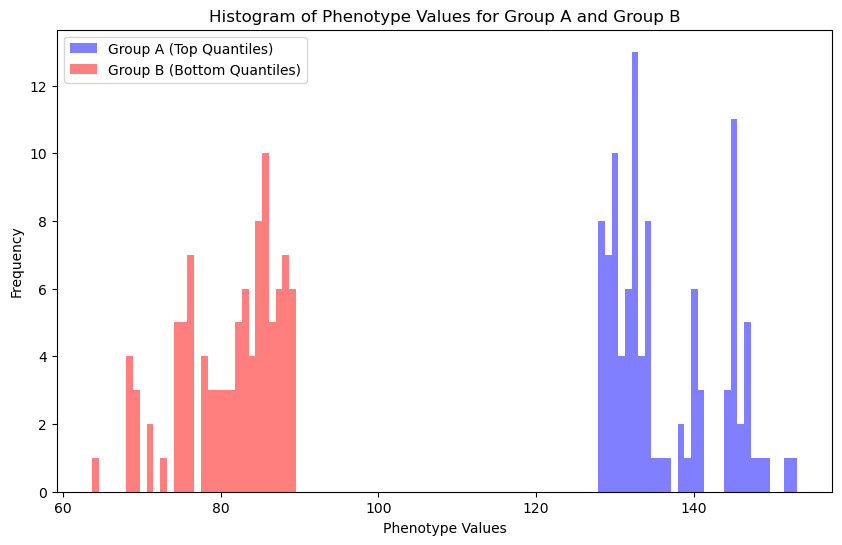

In [3]:
# Define the path for the settings file
settings_filepath = os.path.join(outputfolder, "settings.json")

# Save the settings to a JSON file
with open(settings_filepath, "w") as f:
    json.dump(settings, f, indent=4)

phenotype = settings["phenotype"]
percentile = settings["percentile"]
n_folds = settings["n_folds"]
random_state = settings["random_state"]
n_filters_per_group = settings["n_filters_per_group"]
nPCA = settings["nPCA"]
Tangent_Class = settings["Tangent_Class"]
metric = settings["metric"]
a_label = int(settings["a_label"])
b_label = int(settings["b_label"])
self_whiten = settings["self_whiten"]
deconfound = settings["deconfound"]


a, b = get_groups([phenotype], quantile=percentile, data_path='/project/3022057.01/HCP/combined_data.pkl', regression=False, visualize=True, output_dir=outputfolder)

cov_est = Covariances(estimator='oas')

A_data = np.stack(a["parcellated_data"].to_numpy())
A_covs = cov_est.transform(np.transpose(A_data, (0, 2, 1)))
A_paths = a["paths"].to_numpy()
A_con_confounders = np.stack(a[continuous_confounders].to_numpy())
A_cat_confounders = np.stack(a[categorical_confounders].to_numpy())
A_family_ID = a["Family_ID"].to_numpy()

B_data = np.stack(b["parcellated_data"].to_numpy())
B_covs = cov_est.transform(np.transpose(B_data, (0, 2, 1)))
B_paths = b["paths"].to_numpy()
B_con_confounders = np.stack(b[continuous_confounders].to_numpy())
B_cat_confounders = np.stack(b[categorical_confounders].to_numpy())
B_family_ID = b["Family_ID"].to_numpy()

labels = np.concatenate([a_label*np.ones(len(A_data), dtype=int), b_label*np.ones(len(B_data), dtype=int)])
data = np.concatenate([A_data, B_data], axis=0)
covs = np.concatenate([A_covs, B_covs], axis=0)
paths = np.concatenate([A_paths, B_paths], axis=0)
with open(os.path.join(outputfolder, "paths.pkl"), "wb") as f:
    pickle.dump(paths, f)
con_confounders = np.concatenate([A_con_confounders, B_con_confounders], axis=0)
cat_confounders = np.concatenate([A_cat_confounders, B_cat_confounders], axis=0)
with open(os.path.join(outputfolder, "cat_confounders.pkl"), "wb") as f:
    pickle.dump(cat_confounders, f)
family_ID = np.concatenate([A_family_ID, B_family_ID], axis=0)
with open(os.path.join(outputfolder, "family_ID.pkl"), "wb") as f:
    pickle.dump(family_ID, f)

np.save(os.path.join(outputfolder,"labels.npy"),labels)
np.save(os.path.join(outputfolder,"data.npy"),data)
np.save(os.path.join(outputfolder,"covs.npy"),covs)
np.save(os.path.join(outputfolder,"con_confounders.npy"),con_confounders)

In [4]:
# Stratified k-fold setup
# https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html
sgkf = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
splits = list(sgkf.split(data, labels, groups=family_ID))
run_fold_script = "/project/3022057.01/IFA/run_IFA/run_fold.sh"

# New job per fold
for fold, (train_idx, test_idx) in enumerate(splits):
    # Create Fold Outputfolder
    fold_output_dir = os.path.join(outputfolder, f"fold_{fold}")
    if not os.path.exists(fold_output_dir):
        os.makedirs(fold_output_dir)
    
    indices_dir = os.path.join(fold_output_dir, "Indices")
    if not os.path.exists(indices_dir):
        os.makedirs(indices_dir)
    np.save(os.path.join(indices_dir, "train_idx.npy"), train_idx)
    np.save(os.path.join(indices_dir, "test_idx.npy"), test_idx)

    # Prepare SLURM command to call `run_fold.sh` with arguments for outputfolder and fold
    command = [
        "sbatch",
        "--job-name", f"fold_{fold}",
        "--output", os.path.join(fold_output_dir, "slurm-%j.out"),
        "--error", os.path.join(fold_output_dir, "slurm-%j.err"),
        run_fold_script,  # Path to `run_fold.sh`
        outputfolder,     # Pass outputfolder as first argument
        str(fold)         # Pass fold as second argument
    ]
    
    # Submit the job
    subprocess.run(command)

Submitted batch job 46604172


In [ ]:
from scipy.stats import sem
from pathlib import Path

def load_results(output_folder, prefix, subfold="Demeaned"):
    results = {
        f"{prefix}_var_results": [],
        f"{prefix}_cov_results": [],
        f"{prefix}_Class_Result": ([], []),
        f"{prefix}_recon": ([], [])
    }
    for fold in range(5):
        fold_results_file = Path(output_folder) / f"fold_{fold}" / "Results" / f"{subfold}" /f"{prefix}_results_{subfold.lower()}.pkl"
        with open(fold_results_file, "rb") as f:
            fold_data = pickle.load(f)
        
        for key in results.keys():
            if "Class" in key:
                results[key][0].append(list(fold_data[key].keys()))
                results[key][1].append([fold_data[key][class_key]["accuracy"] for class_key in fold_data[key].keys()])
            elif "recon" in key:
                results[key][0].extend(fold_data[key][0])
                results[key][1].extend(fold_data[key][1])
            else:
                results[key].append(fold_data[key])
    return results

def summarize_results(results):
    summary = {key: [] for key in results.keys()}
    for key, values in results.items():
        values_array = np.array(values if "Class" not in key and "recon" not in key else values[1])
        if "_var_results" in key or "_cov_results" in key:
            summary[key].extend([np.mean(values_array, axis=0), sem(values_array, axis=0)])
        elif "Class" in key:
            classifiers = results[key][0][0]
            avg_accuracy = np.mean(values_array, axis=0)
            std_error = sem(values_array, axis=0)
            summary[key] = (classifiers, avg_accuracy, std_error)
        elif "recon" in key:
            summary[key] = values
    return summary

# Define output folders and load/save results
output_folder = Path(outputfolder)

# Process IFA and ICA results
IFA_all_results_norm = load_results(output_folder, "IFA",subfold="Normalized")
IFA_results_summary_norm = summarize_results(IFA_all_results_norm)

ICA_all_results_norm = load_results(output_folder, "ICA", subfold="Normalized")
ICA_results_summary_norm = summarize_results(ICA_all_results_norm)


# Process IFA and ICA results
IFA_all_results_demean = load_results(output_folder, "IFA",subfold="Demeaned")
IFA_results_summary_demean = summarize_results(IFA_all_results_demean)

ICA_all_results_demean = load_results(output_folder, "ICA", subfold="Demeaned")
ICA_results_summary_demean = summarize_results(ICA_all_results_demean)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from analysis import reconstruction_plot

def plot_model_comparison(x, mean_IFA, sterr_IFA, mean_ICA, sterr_ICA,xlabel="",ylabel="",title="",output_dir="path"):   
    # Increase the spacing between bins
    spacing_factor = 10  # Increased spacing factor from 2 to 3
    x_positions = np.arange(len(x)) * spacing_factor
    
    # Width for offsets (should be less than half of spacing_factor)
    width = (spacing_factor / 5)*0
    
    # Offsets for each method
    offsets = [-width, 0, width]
    
    # Adjust x-values for each method
    x_IFA = x_positions + offsets[0]
    x_ICA = x_positions + offsets[2]
    
    plt.figure(figsize=(12, 6))  # Adjust the width (e.g., 12) to make the figure wider
    # Plotting TSSF, ICA, and FKT with adjusted x-values
    plt.errorbar(x_ICA, mean_ICA, yerr=sterr_ICA, fmt='o', label='ICA', color='orange', capsize=0)
    plt.errorbar(x_IFA, mean_IFA, yerr=sterr_IFA, fmt='o', label='IFA', color='blue', capsize=0)
    
    # Set x-ticks to x_positions without offsets, labels to models
    plt.xticks(x_positions, x, rotation=45, ha='right')

    
    # Formatting plot
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, f'{title}.svg'))

In [ ]:
all_results_output_dir_normalized = output_folder / "Results_Normalized"
all_results_output_dir_normalized.mkdir(parents=True, exist_ok=True)


plot_model_comparison(IFA_results_summary_norm["IFA_var_results"][0][:,0],IFA_results_summary_norm["IFA_var_results"][0][:,2],IFA_results_summary_norm["IFA_var_results"][1][:,2],ICA_results_summary_norm["ICA_var_results"][0][:,2],ICA_results_summary_norm["ICA_var_results"][1][:,2],xlabel="Number of FKT Filters", ylabel="SVM Accuracy", title="Log_Var_Accuracy_Across_Folds",output_dir=all_results_output_dir_normalized)
plot_model_comparison(IFA_results_summary_norm["IFA_var_results"][0][:,0],IFA_results_summary_norm["IFA_var_results"][0][:,1],IFA_results_summary_norm["IFA_var_results"][1][:,1],ICA_results_summary_norm["ICA_var_results"][0][:,1],ICA_results_summary_norm["ICA_var_results"][1][:,1],xlabel="Number of FKT Filters", ylabel="Riemannian Distance", title="Log_Var_Distance_Across_Folds",output_dir=all_results_output_dir_normalized)

plot_model_comparison(IFA_results_summary_norm["IFA_cov_results"][0][:,0],IFA_results_summary_norm["IFA_cov_results"][0][:,2],IFA_results_summary_norm["IFA_cov_results"][1][:,2],ICA_results_summary_norm["ICA_cov_results"][0][:,2],ICA_results_summary_norm["ICA_cov_results"][1][:,2],xlabel="Number of FKT Filters", ylabel="SVM Accuracy", title="Log_Cov_Accuracy_Across_Folds",output_dir=all_results_output_dir_normalized)
plot_model_comparison(IFA_results_summary_norm["IFA_cov_results"][0][:,0],IFA_results_summary_norm["IFA_cov_results"][0][:,1],IFA_results_summary_norm["IFA_cov_results"][1][:,1],ICA_results_summary_norm["ICA_cov_results"][0][:,1],ICA_results_summary_norm["ICA_cov_results"][1][:,1],xlabel="Number of FKT Filters", ylabel="Riemannian Distance", title="Log_Cov_Distance_Across_Folds",output_dir=all_results_output_dir_normalized)

plot_model_comparison(IFA_results_summary_norm["IFA_Class_Result"][0],IFA_results_summary_norm["IFA_Class_Result"][1],IFA_results_summary_norm["IFA_Class_Result"][2],ICA_results_summary_norm["ICA_Class_Result"][1],ICA_results_summary_norm["ICA_Class_Result"][2],xlabel="Model", ylabel="Accuracy", title="Tangent Netmat Accuracy Across Folds",output_dir=all_results_output_dir_normalized)

reconstruction_plot(IFA_results_summary_norm["IFA_recon"][0], ICA_results_summary_norm["ICA_recon"][0],label="Train",output_dir=all_results_output_dir_normalized)
reconstruction_plot(IFA_results_summary_norm["IFA_recon"][1], ICA_results_summary_norm["ICA_recon"][1],label="Test",output_dir=all_results_output_dir_normalized)

In [ ]:
all_results_output_dir_demean = output_folder / "Results_Demeaned"
all_results_output_dir_demean.mkdir(parents=True, exist_ok=True)


plot_model_comparison(IFA_results_summary_demean["IFA_var_results"][0][:,0],IFA_results_summary_demean["IFA_var_results"][0][:,2],IFA_results_summary_demean["IFA_var_results"][1][:,2],ICA_results_summary_demean["ICA_var_results"][0][:,2],ICA_results_summary_demean["ICA_var_results"][1][:,2],xlabel="Number of FKT Filters", ylabel="SVM Accuracy", title="Log_Var_Accuracy_Across_Folds",output_dir=all_results_output_dir_demean)
plot_model_comparison(IFA_results_summary_demean["IFA_var_results"][0][:,0],IFA_results_summary_demean["IFA_var_results"][0][:,1],IFA_results_summary_demean["IFA_var_results"][1][:,1],ICA_results_summary_demean["ICA_var_results"][0][:,1],ICA_results_summary_demean["ICA_var_results"][1][:,1],xlabel="Number of FKT Filters", ylabel="Riemannian Distance", title="Log_Var_Distance_Across_Folds",output_dir=all_results_output_dir_demean)

plot_model_comparison(IFA_results_summary_demean["IFA_cov_results"][0][:,0],IFA_results_summary_demean["IFA_cov_results"][0][:,2],IFA_results_summary_demean["IFA_cov_results"][1][:,2],ICA_results_summary_demean["ICA_cov_results"][0][:,2],ICA_results_summary_demean["ICA_cov_results"][1][:,2],xlabel="Number of FKT Filters", ylabel="SVM Accuracy", title="Log_Cov_Accuracy_Across_Folds",output_dir=all_results_output_dir_demean)
plot_model_comparison(IFA_results_summary_demean["IFA_cov_results"][0][:,0],IFA_results_summary_demean["IFA_cov_results"][0][:,1],IFA_results_summary_demean["IFA_cov_results"][1][:,1],ICA_results_summary_demean["ICA_cov_results"][0][:,1],ICA_results_summary_demean["ICA_cov_results"][1][:,1],xlabel="Number of FKT Filters", ylabel="Riemannian Distance", title="Log_Cov_Distance_Across_Folds",output_dir=all_results_output_dir_demean)

plot_model_comparison(IFA_results_summary_demean["IFA_Class_Result"][0],IFA_results_summary_demean["IFA_Class_Result"][1],IFA_results_summary_demean["IFA_Class_Result"][2],ICA_results_summary_demean["ICA_Class_Result"][1],ICA_results_summary_demean["ICA_Class_Result"][2],xlabel="Model", ylabel="Accuracy", title="Tangent Netmat Accuracy Across Folds",output_dir=all_results_output_dir_demean)

reconstruction_plot(IFA_results_summary_demean["IFA_recon"][0], ICA_results_summary_demean["ICA_recon"][0],label="Train",output_dir=all_results_output_dir_demean)
reconstruction_plot(IFA_results_summary_demean["IFA_recon"][1], ICA_results_summary_demean["ICA_recon"][1],label="Test",output_dir=all_results_output_dir_demean)